In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

# Paper 1 - Uncostrained model 

## Generate synthetic data  
Assume data is generated from the true model  
$$
    Y_i = \mu + \int_{T} x(t)\beta(t) \,dt + \epsilon_i
$$
$$
    \beta(t) = sin(t*\pi/4) \text{ true parameter}
$$
$$
        x(t) = GP(0, K) \text{ synthesized covariate}
$$
$$
    \epsilon_i \sim N(0,\sigma^2)
$$

In [259]:
a = -3
b = 3
g = 2**7 # number of time steps
T = np.linspace(a,b, g) # discretized interval 
n = 100 # number of generated samples

In [248]:
# Rectangle integration
def integrate(f): 
    int = 0;
    for i in np.arange(g-1):
        int = int + (1/2 * (f[i]+f[i+1]) * (b-a)/g)
    return int

In [253]:
# True beta
beta = np.sin(T*np.pi/4)

# Kernel function
def kernel(s,t):
    return np.exp(-2*(t-s)**2)
    
# Kernel matrix
K = np.zeros((g, g))
for s in np.arange(0, g):
    for t in np.arange(0, g):
        K[s,t] = kernel(T[s],T[t])

# Functional covariates
mean = np.zeros(g)
x = np.random.multivariate_normal(mean, K, n)

# Scalar Response
mu = 0
sigma = 0.25 
Y = np.zeros(n) 
for i in np.arange(0,n):
    Y[i] = mu + integrate(x[i,:]*beta) + sigma * np.random.randn()

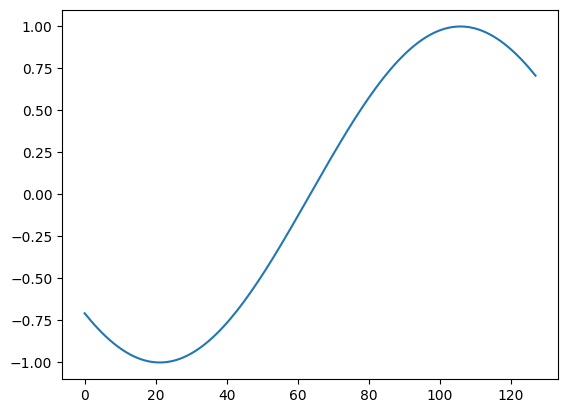

In [250]:
plt.plot(beta)

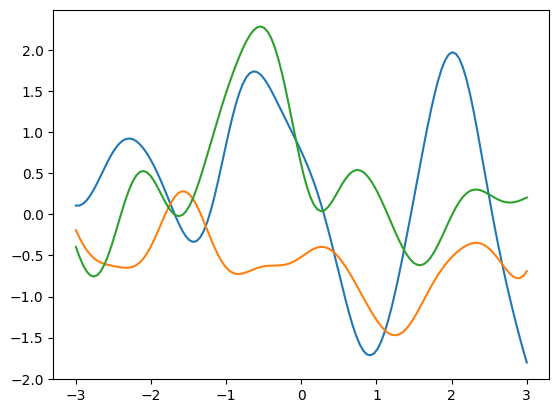

In [251]:
plt.plot(T, x[0,:])
plt.plot(T, x[1,:])
plt.plot(T, x[2,:])

In [260]:
Y # true Y_i

array([-2.83298158, -1.33565563, -1.4930834 , -0.80702755,  0.56845732,
        4.95346007, -1.38386847,  0.63711168, -2.45692505, -3.6008811 ,
       -1.38229249,  2.62715358,  1.64330549,  0.55162152,  0.03945898,
        0.15352262, -0.80796045,  1.27958074,  0.37483545, -2.03405879,
        0.49651668,  0.27517901,  0.63153208,  3.8157671 ,  3.07335843,
       -1.7809807 , -0.82407798, -2.11540067,  1.95041283, -1.29401226,
       -1.25377788,  2.09417405, -2.05922474,  2.52350535, -0.78535958,
       -2.37735585, -0.26764342,  0.14120769,  1.48143903, -2.00956657,
       -3.36586683,  1.14053938, -3.61632522, -2.03003223,  0.81799808,
        0.91714233, -2.5969102 , -1.13705613, -1.24347087, -1.82517183,
       -1.29848793,  1.87051507,  3.80055695,  1.69655222,  3.62527365,
        0.11491734, -4.10512756, -3.66822068,  0.67931779, -0.57417982,
       -0.84105395, -2.35203724,  0.5900154 , -0.45137957, -2.45998826,
        0.51178537, -1.67154686, -2.07453643,  0.73743887,  0.94

## Compute Posterior

Assume the folowing model for the data
$$
    Y_i|\beta \sim N(\int_{T} x_i(t)*\beta(t) dt, \sigma^2)
$$
$$
    \beta \sim GP(0,K)
$$
The posterior distribution for $\beta$ is
$$
    \beta|Y \sim GP(m,K^*)
$$
$$
    m(t) = Lx(t)^{'}(\Sigma + \sigma^2I_n)^{-1}Y
$$
$$
    K^*(s,t) = K(s,t) - Lx(s)^{'}(\Sigma + \sigma^2I_n)^{-1}Lx(t)
$$
with
$$
    Lx(t)^{'} = (Lx_1(t), ..., Lx_n(t))
$$
$$
  Lx_i(t) = \int_{T} K(t,s)x_i(s)ds  
$$
$$
    Y = (Y_1,...,Y_n)^{'}
$$
$$
    \Sigma_{ij} = R(x_i, x_j)
$$
$$
    R(x_i, x_j) = \int_{T} \int_{T} K(s,t)*x_i(s)x_j(t)ds dt
$$

In [254]:
# Compute Lx(t) = (Lx_1(t),...,Lx_n(t))
def Lx(t):   
    L = np.zeros(n)    
    for i in np.arange(0,n):
        L[i] = integrate(K[t, :] * x[i,:])
    return L

# Compute R(i,j)
def R(i, j):
    Ri = np.zeros(g)
    for t in np.arange(0,g):
        Ri[t] = integrate(K[:,t] * x[i,:])
    Rij = integrate(Ri * x[j,:])
    return  Rij

In [255]:
# Compute Σ
S = np.zeros((n,n))
for i in np.arange(0,n):
    for j in np.arange(0,n):
        S[i,j] = R(i,j)

In [256]:
# Compute m(t) and K*(s,t)
inv = np.linalg.inv(S + sigma * np.identity(n))

def m(t):
    mean = np.dot(np.dot(np.transpose(Lx(t)),inv),Y)
    return mean

def Kstar(s,t):
    cov = K[s,t] - np.dot(np.dot(np.transpose(Lx(s)),inv),Lx(t))
    return cov 

In [257]:
M = np.zeros(g)
for t in np.arange(0,g):
    M[t] = m(t)
M

array([-0.6653916 , -0.70041972, -0.73395107, -0.76584336, -0.79599126,
       -0.82431981, -0.85077631, -0.87532167, -0.89792229, -0.91854342,
       -0.93714489, -0.95367984, -0.96809673, -0.98034449, -0.99038047,
       -0.99818018, -1.00374791, -1.00712678, -1.00840694, -1.00773066,
       -1.00529327, -1.00133921, -0.99615304, -0.99004549, -0.98333539,
       -0.97632857, -0.96929527, -0.96244788, -0.95592077, -0.94975405,
       -0.94388285, -0.93813318, -0.93222523, -0.92578414, -0.91835797,
       -0.90944171, -0.89850616, -0.8850297 , -0.86853098, -0.84860043,
       -0.82492853, -0.79732911, -0.76575601, -0.73031229, -0.69125114,
       -0.6489688 , -0.60398951, -0.55694374, -0.50854072, -0.45953693,
       -0.41070213, -0.36278493, -0.31647933, -0.27239414, -0.23102664,
       -0.19274148, -0.15775602, -0.12613241, -0.09777687, -0.07244597,
       -0.04975961, -0.02922009, -0.01023634,  0.00784779,  0.02572231,
        0.04407855,  0.06357647,  0.08481347,  0.10829606,  0.13

In [258]:
Kst = np.zeros((g,g))
for s in np.arange(0,g):
    for t in np.arange(0,g):
        Kst[s,t] = Kstar(s,t)

Kst

array([[0.12465066, 0.1032529 , 0.08126775, ..., 0.00662616, 0.00771011,
        0.00866455],
       [0.1032529 , 0.08728334, 0.07046372, ..., 0.00673697, 0.00773414,
        0.00860041],
       [0.08126775, 0.07046372, 0.05866677, ..., 0.00678137, 0.00768245,
        0.0084525 ],
       ...,
       [0.00662616, 0.00673697, 0.00678137, ..., 0.07391595, 0.0872107 ,
        0.09929552],
       [0.00771011, 0.00773414, 0.00768245, ..., 0.0872107 , 0.10567659,
        0.12305926],
       [0.00866455, 0.00860041, 0.0084525 , ..., 0.09929552, 0.12305926,
        0.14598897]])

## Simulate from the posterior

Text(0.5, 1.0, 'Sample from beta posterior')

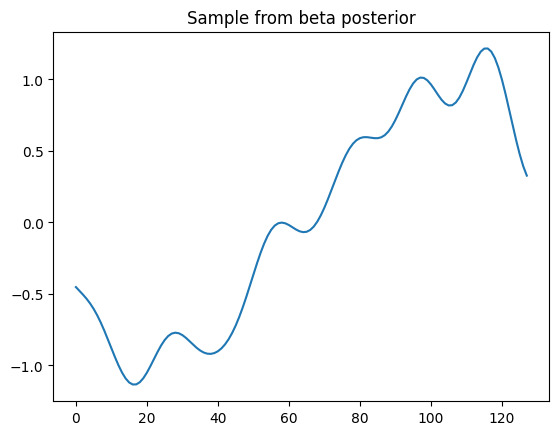

In [261]:
beta_p = np.random.multivariate_normal(M,Kst)
plt.plot(beta_p)
plt.title('Sample from beta posterior')

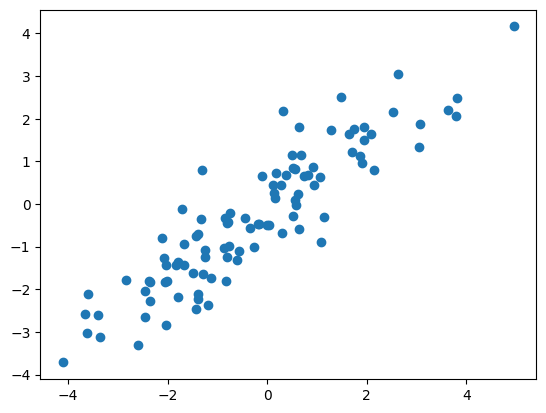

In [262]:
# Predict Y_i from the beta_p
y_pred = np.zeros(n) # np.random.multivariate_normal(np.zeros(n),S + sigma * np.identity(n))

for i in np.arange(0,n):
    y_pred[i] = mu + integrate(x[i,:]*b_post) + sigma * np.random.randn()

# Confront with the true Y_i
plt.scatter(Y,y_pred)

## Sample from the marginal of Y
The marginal distribution of Y is
$$
    Y \sim N_n(0, \Sigma + \sigma^2I_n)
$$

In [263]:
y_sampled = np.random.multivariate_normal(np.zeros(n),S + sigma * np.identity(n))
y_sampled

array([ 0.84803309, -0.1995977 , -0.06600947, -0.01273504, -0.17938649,
        0.13567545, -1.77262101, -1.47522112, -0.90677046,  0.37510871,
        2.039819  ,  0.32591762, -1.26009194, -0.64674096, -1.45105686,
       -1.0452696 , -0.40561816,  0.47193101, -0.69766323,  1.21711709,
        1.55054004, -1.54321467,  2.35390504, -2.22287497, -2.08278514,
       -1.16271495, -0.98719209,  1.67132838,  0.22198878, -1.53725193,
        0.13171647, -0.35048275, -0.5121565 , -0.83005008, -0.74089057,
        1.05830384,  0.06098728,  1.61836504,  0.9113846 ,  1.391791  ,
        0.03483871, -2.07741337,  0.28120723, -1.86645451,  0.2931604 ,
       -0.17173886, -0.64836576, -4.75786006,  0.1351941 , -1.42820726,
        2.73898931, -2.06608124, -1.49132905,  0.22871727, -1.67093442,
        1.7672357 , -0.02019322,  1.9148645 , -0.17743728,  0.19168435,
       -1.66468913, -0.63432453, -0.77251761, -0.97480057,  1.28654251,
       -0.75529387,  1.31479945,  1.35853503,  0.93159051,  0.09